# Tackle the possibilities to know the maximum reliable value for inclination

Equation (54) of paper:
\begin{equation}
\theta_1\cot\theta_1 = 2\beta I_k(\theta)\cot\theta - \frac{2\beta}{k+2}\left(1-\cos^{k+2}\theta\right)
\end{equation}

$\theta_1$ has no real values for $\theta>\frac{\pi}{2}$, which is likely to be the assymptotic angle $\theta_\infty$. So I proposed a set of solutions

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,"../")
from equation6 import Shell

In [3]:
xi=0.8
beta=0.01

In [11]:
shell = Shell(beta=beta,innertype="anisotropic",xi=xi)
theta = np.linspace(0,np.pi)
R = shell.radius(theta)
R[R<=0] = np.nan
x,y = R*np.cos(theta),R*np.sin(theta)

In [5]:
sns.set_context("poster")

## Find $\theta$ such that the CRW and the conic equivalent start to diverge

Compute $\alpha = -\frac{dy}{dx}$ for the ellipse and we should stop relying in the conic fit when $\alpha=0$

In [6]:
def A(b, xi):
    """
    Returns the radius of curvature normalized with R0

    Corrected version that also depends on anisotropy index k

    xi = 2/(k+2) => k = 2 (1/xi - 1)
    """
    k = 2*(1./xi - 1.)
    sb = np.sqrt(b)
    c = (1 - b - 9.0*k/4.0)/30.0
    alpha = (1.0 + 2*sb)/6.0 + c/(1 + sb)
    return 1./(1.0-2*alpha)

In [7]:
def theta_c(beta,xi=1.0):
    """
    theta_c defines the excentricity of a given conic
    """
    Acurv = A(beta,xi)
    arg = 2*Acurv - 3*xi*(1.0 + np.sqrt(beta))**2/(1.0 - xi*beta)**2/(1 + 0.2*xi*beta)
    return np.sign(arg)*np.arctan(np.sqrt(np.abs(arg)))

In [8]:
def B(beta,xi=1.0):
    """
    Returns R90 normalized with R0
    """
    return np.sqrt(3*xi*(1.0 + np.sqrt(beta))**2/(1.0 - xi*beta)**2/(1 + 0.2*xi*beta))

In [9]:
R0 = R[0]
a = R0*A(beta,xi)/(2*A(beta,xi)-(B(beta,xi))**2)
b = R0*A(beta,xi)/np.sqrt(2*A(beta,xi)-(B(beta,xi))**2)
x0 = a -R0
t = np.linspace(-np.pi,np.pi)
xe = a*np.cos(t)-x0
ye = b*np.sin(t)

The conversion between t and $\theta$ is
$$\tan\theta = \frac{y}{x} = \frac{b\sin t}{a\cos t -x_0}$$

So, for $\theta$ limit $\theta_{stop}$ we find that
$$\tan\theta_{stop} = -\frac{b}{x_0}$$

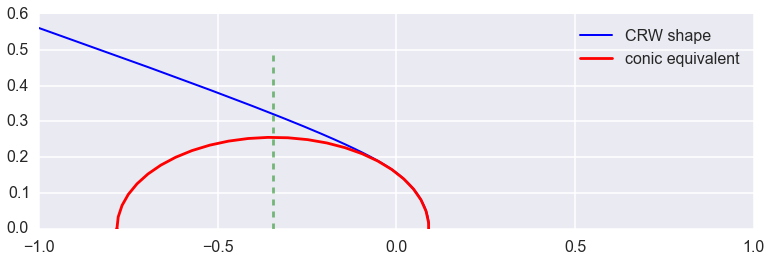

In [12]:
thinfq = np.arctan2(b,-x0)
#Rq = shell.radius(2.5)
#yq = Rq*np.sin(2.5)
plt.plot(x,y,"b-",lw=2,label="CRW shape")
plt.plot(xe,ye,"r-",label="conic equivalent")
plt.plot([-x0,-x0],[0,0.5],"g--",alpha=0.5)
#plt.plot([0.0,-x0],[0.0,yq],"m--")
plt.legend()
plt.xlim(-1,1)
plt.ylim(0,0.6)
plt.gca().set_aspect("equal");

This doesn't lead us to $\theta_\infty$, but to the point we may stop relying in the conic equivalent, which is _before_
$\theta_\infty$

## $\theta_\infty$ for non isotropic case

For the non isotropic case the inner wind mass loss truncates at $\theta = \frac{\pi}{2}$. So, the equation (54) of
paper does not apply for $\theta > \frac{\pi}{2}$ if $k > 0$. Instead, we got that the equivalent of equation (54) is:
\begin{align}
\theta_1\cot\theta_1 &= 2\beta I \cot\theta -\frac{2\beta}{k+2} \\
\mathrm{where~}  I &= \int^{\frac{\pi}{2}}_{0} \cos^k\theta\sin^2\theta~d\theta = \frac{\sqrt{\pi}\Gamma\left(\frac{k+1}{2}\right)}{4\Gamma\left(\frac{k}{2}+2\right)}
\end{align}

With this we can obtain $\theta_\infty$ defined as $\theta_\infty + \theta_{1\infty} = \pi$ solving the implicit equation for $\theta_\infty$:

$$\theta_\infty - \frac{k+2(1-\beta)}{k+2}\tan\theta_\infty = \pi + 2\beta I$$

In [17]:
from scipy.optimize import fsolve
from scipy.special import gamma as gamma_func

In [33]:
def finf(th,*args):
    beta,xi = args
    k = 2./xi-2
    C = (k+2*(1-beta))/(k+2)
    I = np.sqrt(np.pi)*gamma_func(0.5*(k+1))/(4*gamma_func(0.5*k+2))
    D = np.pi + 2*beta*I
    return th - C*np.tan(th) -D

In [44]:
for i in [0.5,0.6,0.7,0.8,0.9,1.0]:
    thinf = fsolve(finf,i*np.pi,args=(beta,xi))
    print(np.degrees(thinf))

[ 90.00000134]
[ 161.19856733]
[ 161.19856733]
[ 161.19856733]
[ 161.19856733]
[ 185.15811385]


/fs/posgrado01/other0/jtarango/anaconda3/lib/python3.4/site-packages/scipy/optimize/minpack.py:237: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


It is a bit sensitive to initial conditions. Works well for an initial $\theta$ greater than $\frac{\pi}{2}$ but less than $\pi$

In [45]:
thinf = fsolve(finf,0.6*np.pi,args=(beta,xi))

(0, 1.5)

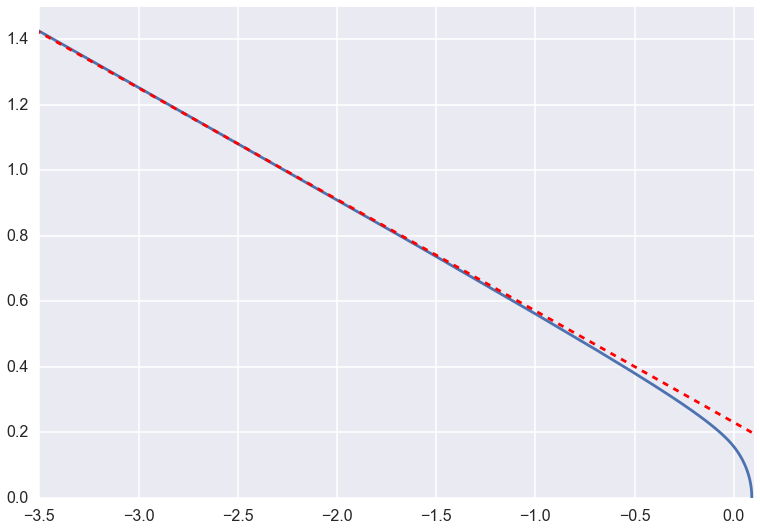

In [60]:
plt.plot(x,y)
m = np.tan(thinf)
plt.plot(x,m*x+0.23,"r--")
plt.xlim(-3.5,0.1)
plt.ylim(0,1.5)

Looks like it worked. 